# Week of 2025.06.02

Let's remind ourselves that the end goal is to be able to make accurate acoustic pressure predictions from our model of the volcano. In order to do that, we need to have faith in the axisymetric atmosphere model that Fred added. At the moment, there are still aspects of that model I do not understand. Our goal this week is to better understand that model. 

## TODO
- [x] Model 1D conduit. Make the atmosphere also 1D. 
- [x] Compare analytical and numerical results.
- [x] Email Fred to see if he has any ideas about why adding the atmosphere affects the conduit model.
- [x] Experiment with different pressures and temperatures to see if that changes the model much.

### Re-run full simulation with the following changes 
- [x] Keep in mind that radius, not diameter, is m. 

## Notes for future work:

I emailed Fred about some of the challenges we are seeing in this notebook. His response was this:
> I think this might be an issue with numerical diffusion. An interface between magma and air can start sharp but will start to diffuse because of the way the numerical flux is defined, even if the interface is not moving. This causes air to "leak" to the magma side and the magma to "leak" to the air side. I suspect this is what's happening here, giving rise to a weird pressure distribution near the exit of the conduit.

> One way to check this is to look at the air mass fraction in the conduit. If the air mass fraction is higher than expected in the conduit, then this leakage is leading to perturbations near the top of the conduit.

>You would probably see the same thing if you had coupled the conduit to a "1D atmosphere" instead of a 2D atmosphere.

>If this turns out to be the issue, then we can tackle it one of two ways: 1) work around the issue (for example, by solving the uncoupled conduit problem with the pressure boundary condition until the plug fails completely, and then loading the simulation state into the coupled problem as an initial condition); or 2) improve the numerical treatment so that material interfaces (e.g., the interface between air and magma/rock) are well-captured. I'm not sure how to do the latter, since the numerical "answer" to the problem might be a combination of changes to the numerical flux and adding interface sharpening terms, which can get quite involved and will take some time (I'm not sure how long you'll be working on this project vs. how long it will take to find the solution). On the other hand, figuring out the numerical problem can let us look at other interesting problems involving lava lakes and underwater eruptions that I haven't been able to look at before.


### Atmosphere 
- [x] How does atmosphere coupling work? Does it matter how far down into the conduit the atmosphere is simulated? The depth dictates where the transition boundary is. It only metters in order to generate a "vertical column" of pressure rather than radiating outwards.

## Vertical conduit mesh

Our first goal this week is to create a vertical mesh to simplify the simulation and verify that the wave properties behave as intended. Let's make the mesh go 50 meters deep into the conduit and then 250m into the air.

In [51]:
%load_ext autoreload
%autoreload 2

In [274]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func, get_quantities_at_conduit_exit
from helper_code.animate import animate_conduit_pressure

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

/Users/paxton/git/quail_volcano/src

Points: (2679, 3)
Cells: dict_keys(['line', 'triangle'])
Cell Sets: {}


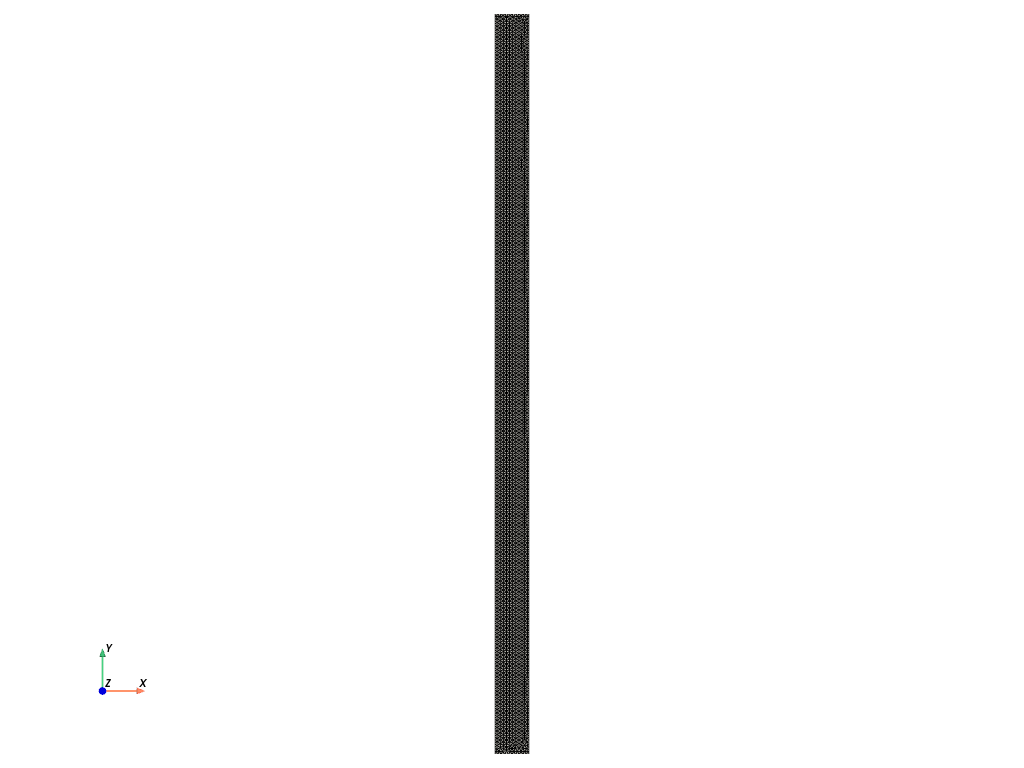

In [372]:
import meshio
import pyvista as pv
import os

print(os.getcwd())

mesh = meshio.read(f"{BASE_PATH}/quail_volcano/scenarios/meshes/vertical_conduit.msh")

# Clear cell sets to avoid the error
mesh.cell_sets.clear()

# Print mesh details
print("Points:", mesh.points.shape)
print("Cells:", mesh.cells_dict.keys())
#for cell_type, cell_data in mesh.cells_dict.items():
    #print(f"Cell type {cell_type}: {cell_data.shape}")
print("Cell Sets:", mesh.cell_sets)
#print("Cell Data:", mesh.cell_data)

pv.set_jupyter_backend('static')

# Convert to pyvista mesh
pv_mesh = pv.from_meshio(mesh)

# Create a plotter and visualize
plotter = pv.Plotter()

plotter.add_mesh(pv_mesh, show_edges=True, color="white")
plotter.set_scale(xscale=1.0, yscale=1.0, zscale=1.0)
plotter.camera.roll += 80

plotter.view_xy()  # For 2D meshes; use view_isometric() for 3D
plotter.show_axes()
plotter.show()

## Let's then review the "eruption" we are experimenting with. 

In [34]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

ITERS = 50
D_ITERS = 1
END_TIME = 20
C0 = 320 # m/s at 5000m

In [ ]:
file_name = "short_plug_v12"
iters = 50
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=D_ITERS,
    viscosity_index=2,
    wall_friction_index=1,
    max_velocity=5,
    max_slip=60,
    max_tau=1.5,
    max_pressure=50,
    max_speed_of_sound=1000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)
HTML(ani.to_html5_video())

## "Eruption" with added atmosphere

In [424]:
file_name = "short_plug_v19"
iters = 50
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=5,
    viscosity_index=2,
    wall_friction_index=1,
    max_velocity=5,
    max_slip=60,
    max_tau=1.5,
    max_pressure=20,
    max_speed_of_sound=1000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
    y_min=-200,
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)
HTML(ani.to_html5_video())

## Let's review the pressure and velocity at the outlet (y=0)

- The velocity and pressure from the two eruptions are not very similar even though in theory the setup is precisely the same except for the atmosphere integration.
- The velocity and pressure curves start to look more similar once we go in a couple steps. Perhaps the indicates the issue is with the number of steps. 

In [390]:
file_name = "short_plug_v17"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_atm, p_atm, u_atm, temp_atm = get_quantities_at_conduit_exit(solver_func, iterations=100, compute_temp=True, conduit_index=-1)

file_name = "short_plug_v12"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_original, p_original, u_original, _ = get_quantities_at_conduit_exit(solver_func, iterations=50, compute_temp=True, conduit_index=-1)

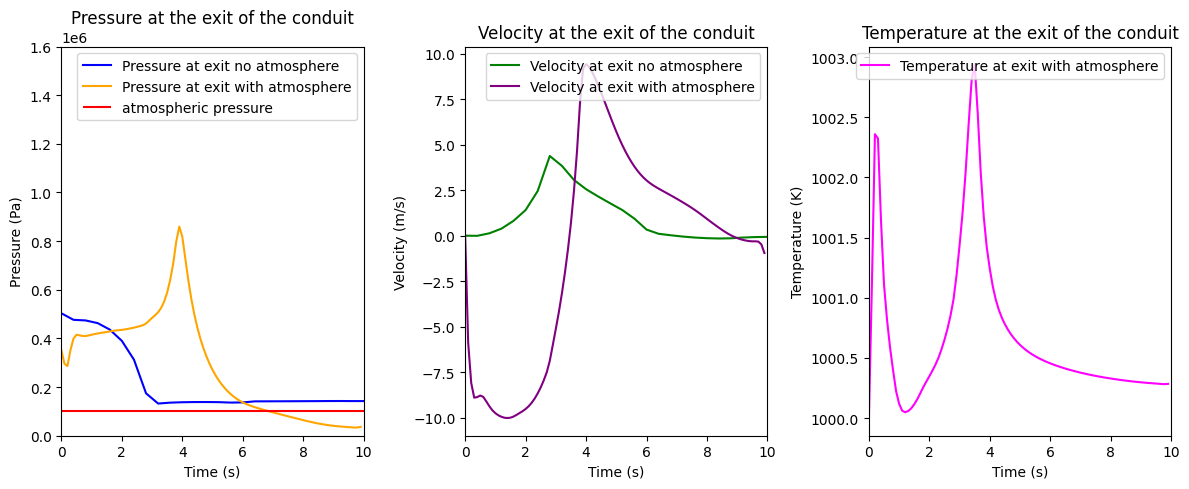

In [391]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming t_vec and p_vec are defined; if not, here's a placeholder for demonstration
# t_vec = np.linspace(0, 10, 100)
# p_vec = np.sin(t_vec) * 0.5e6  # Example data

# Create figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

# First plot
ax1.plot(t_original, p_original, label="Pressure at exit no atmosphere", color="blue")
ax1.plot(t_atm, p_atm, label="Pressure at exit with atmosphere", color="orange")
ax1.hlines(y=1e5, xmin=0, xmax=20, color="red", label="atmospheric pressure")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Pressure (Pa)")
ax1.set_title("Pressure at the exit of the conduit")
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 16e5)
ax1.legend()

# Second plot (identical)
ax2.plot(t_original, u_original, label="Velocity at exit no atmosphere", color="green")
ax2.plot(t_atm, u_atm, label="Velocity at exit with atmosphere", color="purple")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Velocity (m/s)")
ax2.set_title("Velocity at the exit of the conduit")
ax2.set_xlim(0, 10)
ax2.legend()

# Third plot (identical)
ax3.plot(t_atm, temp_atm, label="Temperature at exit with atmosphere", color="magenta")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Temperature (K)")
ax3.set_title("Temperature at the exit of the conduit")
ax3.set_xlim(0, 10)
ax3.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Let's review the vertical simulation again with some changes
1. Reduce the conduit below the surface to 30 meters (this is where the 1d -> 2d boundary is). 30m is three times the radius which is roughly the same ratio Fred used when he was writing about the atmosphere coupling. 
2. Increase the vertical height of the conduit to 500m. That will allow the simulation to run a little bit longer. 
3. Increase the size of each element to have 3m sides. That means that about three triangles can fit between the conduit walls. I should probably reduce this to 2 at some point. 


Let's also try to plot some more information like temperature. 

**Notes**
1. I realized I had been ignoring negative velocity with my monopole model. That should help the system look more similar. 

In [ ]:
import matplotlib
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import processing.mdtools as mdtools

file_name = "short_plug_v17"

iters = 100

solver_func = get_local_solver_from_index_func(folder_name, file_name)
solver2D_atm1 = get_local_solver_from_index_func("simple_conduit", "test_infrasound_vertical_conduit_v2_atm1")

u_vec = []
t_vec = []
R = 10 # m

for i in range(0, iters, 1):
    solver = solver_func(i)
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
    rho = np.sum(solver.state_coeffs[:, :, solver.physics.get_mass_slice()],axis=2,keepdims=True)

    # Define velocity as momentum divided by density
    u = momentum.ravel() / rho.ravel()

    # Take only the exit velocity
    u_vec.append(u[-3])
    t_vec.append(solver.time)

a_vec = np.gradient(np.array(u_vec), np.array(t_vec))
Q_dot_vec = np.pi * R**2 * a_vec # m^3/s^2
Q_vec = np.pi * R**2 * np.array(u_vec) # m^3/s

N = 100
pressure_array = np.zeros((len(t_vec), N, N))
x_low, x_upper = -100, 100
y_low, y_upper = -50, 1000

X = np.linspace(x_low, x_upper, N)
Y = np.linspace(y_low, y_upper, N)

# Set up the figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
im1 = ax1.imshow(pressure_array[0], extent=[x_low, x_upper, y_low, y_upper], 
                aspect='auto', cmap=matplotlib.cm.PiYG, origin='lower', vmin=-1e4, vmax=1e4)
clims = [-1e4 + 1e5, 1e4 + 1e5]
t_clims = [0, 1e3]

# Initialize second plot with empty data
x1, p1 = mdtools.downsample(solver2D_atm1(0), plot_qty="Pressure")
x1, p1_0= mdtools.downsample(solver2D_atm1(0), plot_qty="Pressure")
im2 = mdtools.plot_mean(x1, p1 - p1_0, clims, ax=ax2, cmap=matplotlib.cm.PiYG)

x1, t1 = mdtools.downsample(solver2D_atm1(0), plot_qty="Temperature")
im3 = mdtools.plot_mean(x1, t1, t_clims, ax=ax3, cmap=matplotlib.cm.PiYG)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=matplotlib.cm.PiYG
)
cb = plt.colorbar(sm, ax=ax2)
cb.set_label("Pressure (Pa)")

sm3 = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=t_clims[0], vmax=t_clims[1]),
    cmap=matplotlib.cm.PiYG
)
cb = plt.colorbar(sm3, ax=ax3)
cb.set_label("Temperature (K)")

plt.colorbar(im1, ax=ax1, label='Pressure (Pa)')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title('Pressure Distribution Over Time (Original)')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('Pressure Distribution Over Time (Downsampled)')
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_title('Temperature Distribution Over Time (Downsampled)')
plt.tight_layout()

# Initialization function for animation
def init():
    im1.set_array(np.zeros((N, N)))
    x1, p1 = mdtools.downsample(solver2D_atm1(0), plot_qty="Pressure")
    im2 = mdtools.plot_mean(x1, p1, clims, ax=ax2)
    x1, t1 = mdtools.downsample(solver2D_atm1(0), plot_qty="Temperature")
    im3 = mdtools.plot_mean(x1, t1, t_clims, ax=ax3)
    return [im1, im2, im3]

# Animation update function
def update(t_idx):
    t = t_vec[t_idx]
    # Update first plot (original)
    for i in range(N):
        for j in range(N):
            x = X[i]
            y = Y[j]
            if infrasound.point_inside_vertical_conduit(x, y):
                pressure_array[int(t_idx), j, i] = infrasound.relative_pressure_vertical_conduit(t, x, y, t_vec, Q_vec)
            else:
                pressure_array[int(t_idx), j, i] = np.nan  # Set pressure to NaN inside volcano

    im1.set_array(pressure_array[int(t_idx)])
    ax1.set_title(f'Monopole Pressure Distribution at t={t:.2f} s')

    # Update second plot (downsampled)
    x1, p1 = mdtools.downsample(solver2D_atm1(t_idx), plot_qty="Pressure")
    im2 = mdtools.plot_mean(x1, p1, clims, ax=ax2)
    ax2.set_title(f'Quail Pressure Distribution at t={t:.2f} s')

    # Update third plot (temperature)
    x1, t1 = mdtools.downsample(solver2D_atm1(t_idx), plot_qty="Temperature")
    im3 = mdtools.plot_mean(x1, t1, t_clims, ax=ax3)
    ax3.set_title(f'Quail Temperature Distribution at t={t:.2f} s')

    if t_idx % 10 == 0:
        print(f"Frame {t_idx} at time {t:.2f} s")

    return [im1, im2, im3]

# Create animation
print("Creating animation...")
ani = FuncAnimation(fig, update, init_func=init, frames=range(0, iters, 10), 
                    interval=200, blit=True)

#ani.save(f'{BASE_PATH}/volcano_sims/notebooks/animations/monopole_source_dual_downsampled.mp4', writer='ffmpeg', fps=10, bitrate=1800)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

Creating animation...
Frame 0 at time 0.00 s
Frame 10 at time 1.00 s
Frame 20 at time 2.00 s
Frame 30 at time 3.00 s
Frame 40 at time 4.00 s
Frame 50 at time 5.00 s
Frame 60 at time 6.00 s
Frame 70 at time 7.00 s
Frame 80 at time 8.00 s
Frame 90 at time 9.00 s


In [420]:
import matplotlib.tri as tri
from helper_code.infrasound import *
solver_2D = solver2D_atm1(0)

triangulation = tri.Triangulation(solver_2D.mesh.node_coords[...,0],
                  solver_2D.mesh.node_coords[...,1], 
                  triangles=solver_2D.mesh.elem_to_node_IDs)
trifinder = triangulation.get_trifinder()

p_0_quail = infrasound.get_p_series(5, 0, solver2D_atm1, trifinder, iterations=100, p0=1e5)
p_100_quail = infrasound.get_p_series(5, 100, solver2D_atm1, trifinder, iterations=100, p0=1e5)
p_200_quail = infrasound.get_p_series(5, 200, solver2D_atm1, trifinder, iterations=100, p0=1e5)

Element ID for point (5, 0): 2037
Element ID for point (5, 100): 1917
Element ID for point (5, 200): 1794


In [404]:
p_0_monopole = pressure_array[:, np.argmin(np.abs(Y - 5)), np.argmin(np.abs(X-5))]
p_100_monopole = pressure_array[:, np.argmin(np.abs(Y - 100)), np.argmin(np.abs(X-5))]
p_200_monopole = pressure_array[:, np.argmin(np.abs(Y - 200)), np.argmin(np.abs(X-5))]

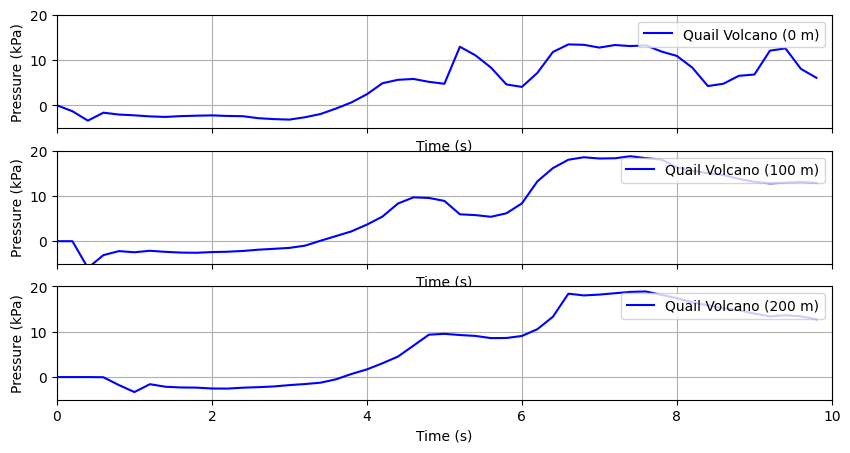

In [423]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 5), sharex=True)


t_quail = np.linspace(0, 9.8, len(p_0_quail))
t_monopole = np.linspace(0, 9.8, len(p_0_monopole))

axes[0].plot(t_quail, np.asarray(p_0_quail)/1e3, label='Quail Volcano (0 m)', color='blue')
#axes[0].plot(t_monopole, np.asarray(p_0_monopole)/1e3, label='Monopole (0 m)', color='red')
axes[1].plot(t_quail, np.asarray(p_100_quail)/1e3, label='Quail Volcano (100 m)', color='blue')
#axes[1].plot(t_monopole, np.asarray(p_100_monopole)/1e3, label='Monopole (100 m)', color='red')
axes[2].plot(t_quail, np.asarray(p_200_quail)/1e3, label='Quail Volcano (200 m)', color='blue')
#axes[2].plot(t_monopole, np.asarray(p_200_monopole)/1e3, label='Monopole (200 m)', color='red')

for i, ax in enumerate(axes):
    ax.legend(loc='upper right')
    ax.grid(True)
    ax.set_ylim(-5, 20)  
    ax.set_xlim(0, 10)
    ax.set_ylabel('Pressure (kPa)')
    ax.set_xlabel('Time (s)')

### Could it be my challenges are related to the melt/atmosphere overlapping? 

Short answer. No. Even when I modify the y values to go from 0 -> 250 (no negative values) we see the same behavior.

### Could it be the large difference in temp? 

Melt is at around 1000k while the atmosphere is at around 300k. Let's reducing the temp of the volcano and see if that resolves my challenges a little bit. Well it turns out the temp of the volcano is hard to change. Even if I reduce the initial condition temperature, shortly after the initial time step the volcano temp pops back to 1000k... I tried increasing the temperature of the atmosphere to see if that affects the situation. I still don't really see how tempature would affect the initial negative velocity.

As far as my experiments have shown, there is not clear signal between temp and the odd behavior I am seeing.

### Try reducing the pressure in the atmosphere to 0.5e5. That in theory should help maintain a positive velocity. 

This also did not make a huge difference.

### if even after reducing the pressure, we still see negative velocity look at conservation code + email Fred. 

Check. Emailed Fred. Fred things the error we are seeing is a likely a function of numerical diffusion. Even though the boundary is fixed, Fred things the diffusion at the boundary is somehow allowing the volcano melt to increase in pressure. 

## Simulate a small piece of vertical conduit at a higher spatial resolution

atmosphere dx = 2 [m]
conduit dx = 1 [m]

The higher resolution does not appear to affect things all that much. That said, if we look at the pressure and velocity a couple steps into the melt the two models appear more similar.

In [394]:
file_name = "short_plug_v19"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_atm, p_atm, u_atm, temp_atm = get_quantities_at_conduit_exit(solver_func, iterations=50, compute_temp=True, conduit_index=-5)

file_name = "short_plug_v12"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_original, p_original, u_original, _ = get_quantities_at_conduit_exit(solver_func, iterations=50, conduit_index=-2)

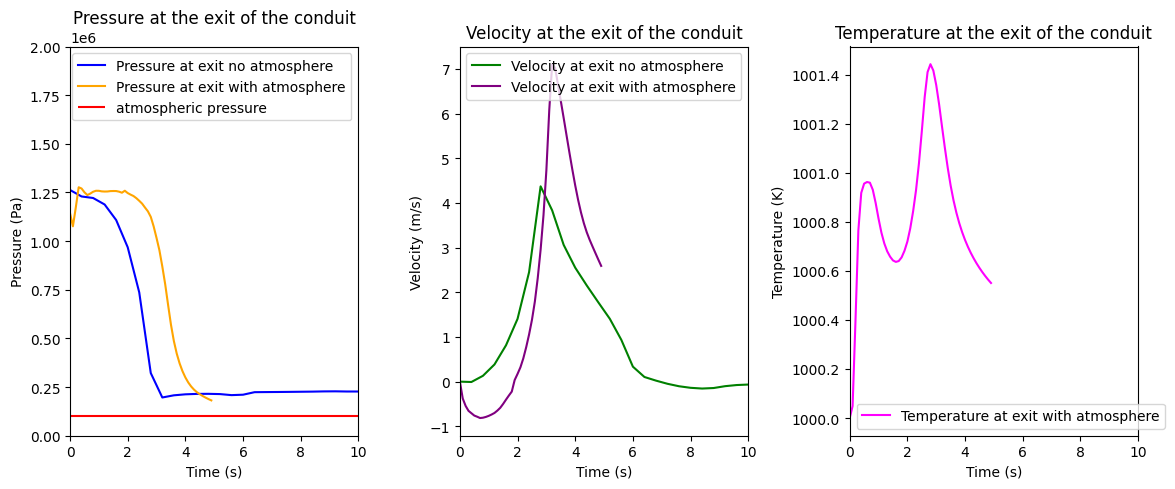

In [395]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming t_vec and p_vec are defined; if not, here's a placeholder for demonstration
# t_vec = np.linspace(0, 10, 100)
# p_vec = np.sin(t_vec) * 0.5e6  # Example data

# Create figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

# First plot
ax1.plot(t_original, p_original, label="Pressure at exit no atmosphere", color="blue")
ax1.plot(t_atm, p_atm, label="Pressure at exit with atmosphere", color="orange")
ax1.hlines(y=1e5, xmin=0, xmax=20, color="red", label="atmospheric pressure")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Pressure (Pa)")
ax1.set_title("Pressure at the exit of the conduit")
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 2e6)
ax1.legend()

# Second plot (identical)
ax2.plot(t_original, u_original, label="Velocity at exit no atmosphere", color="green")
ax2.plot(t_atm, u_atm, label="Velocity at exit with atmosphere", color="purple")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Velocity (m/s)")
ax2.set_title("Velocity at the exit of the conduit")
ax2.set_xlim(0, 10)
ax2.legend()

# Third plot (identical)
ax3.plot(t_atm, temp_atm, label="Temperature at exit with atmosphere", color="magenta")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Temperature (K)")
ax3.set_title("Temperature at the exit of the conduit")
ax3.set_xlim(0, 10)
ax3.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()